In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
import random
from plot_lib import *
from ultralytics import YOLO
from ultralytics.yolo.data.augment import LetterBox
from ultralytics.yolo.utils.ops import non_max_suppression as nms

%matplotlib inline
%config InlineBackend.figure_format ="retina"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def set_seed(seed=114514):
    random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_seed()

In [2]:
yolo_model = YOLO("weights/yolov8m.pt")
yolo_model.to(device)
model = yolo_model.model
model.eval()

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
   

In [3]:
model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

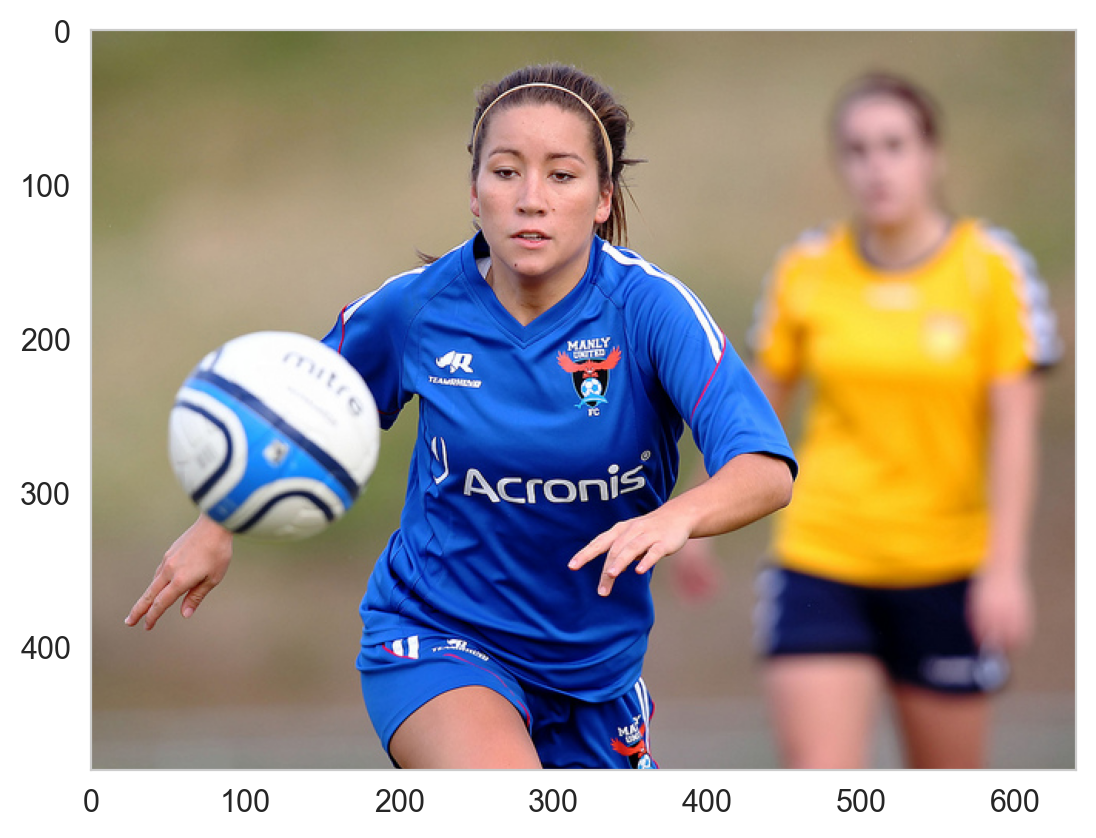

In [4]:
img = cv2.imread("coco-pictures/image2.jpg")[..., ::-1]
plot_single_image(img)

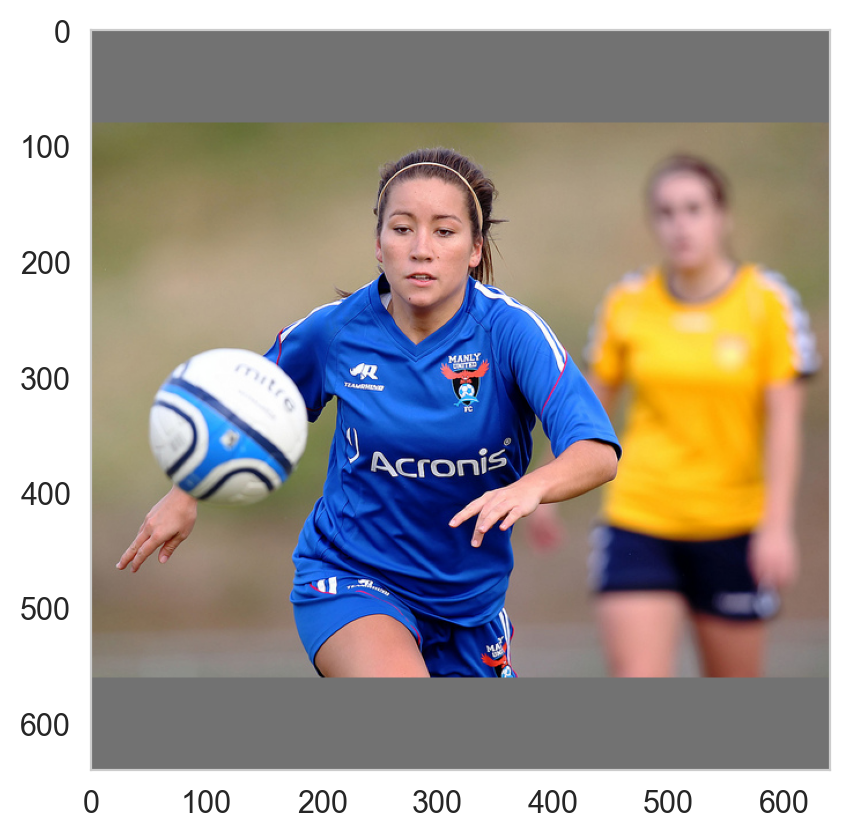

torch.Size([3, 640, 640])


In [5]:
conf_threshold = 0.25
img_size = yolo_model.overrides['imgsz']
stride = model.stride

letter_box = LetterBox(new_shape=img_size, stride=stride)
transform = transforms.Compose([
    transforms.ToTensor(),
])

input_img0 = letter_box(image=img)
plot_single_image(input_img0)

inputs = transform(input_img0)
print(inputs.shape)

In [6]:
plot_multi_heatmaps(*inputs)
inputs = inputs.unsqueeze(0).to(device)
print(inputs.shape)

torch.Size([1, 3, 640, 640])


In [7]:
outputs = model(inputs)
print(outputs[0].shape)
for i in outputs[1]:
    print(i.shape)

torch.Size([1, 84, 8400])
torch.Size([1, 144, 80, 80])
torch.Size([1, 144, 40, 40])
torch.Size([1, 144, 20, 20])


In [8]:
pred = outputs[0]
head_shapes = [80, 40, 20]
heads = []
start_i = 0
for i, p in enumerate(head_shapes):
    heads.append(pred[..., start_i:start_i+p**2].reshape(len(model.names)+4, p, p))
    start_i += p ** 2
print(*[i.shape for i in heads], sep="\n")

torch.Size([84, 80, 80])
torch.Size([84, 40, 40])
torch.Size([84, 20, 20])


In [9]:
nms_preds = nms(outputs[0])[0].cpu().numpy()
nms_preds

array([[     49.369,      274.64,      188.78,      412.35,      0.9661,          32],
       [     21.056,      101.62,      459.94,      554.92,     0.96438,           0],
       [      425.7,      107.58,      631.72,      554.35,      0.9429,           0]], dtype=float32)

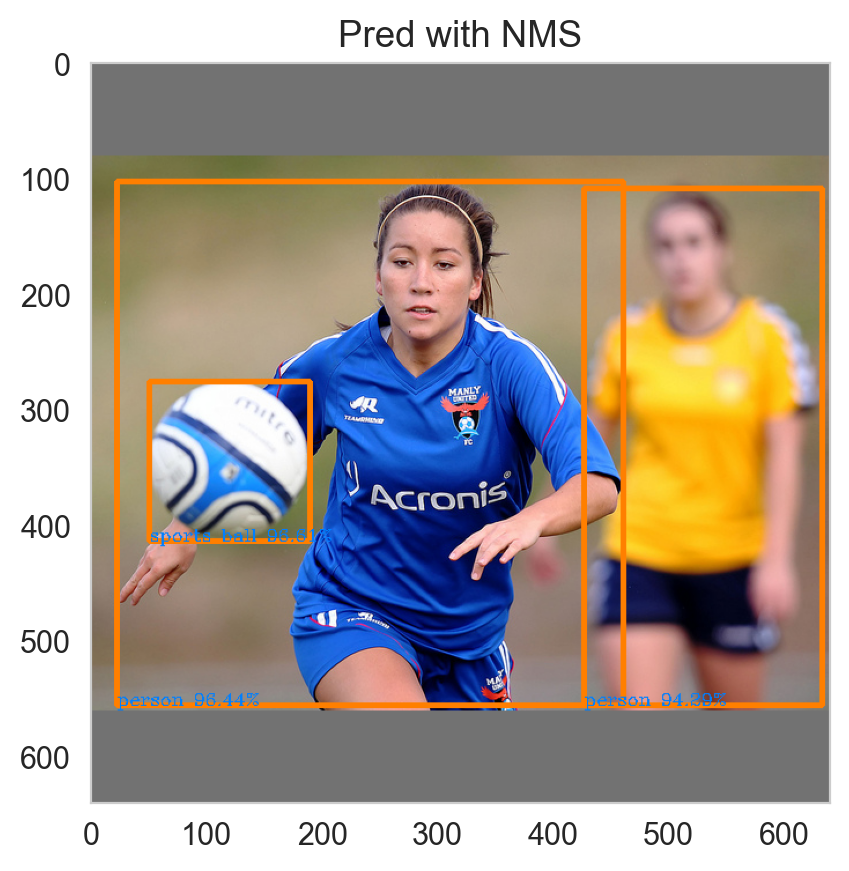

In [10]:
input_img = input_img0.copy()
for *xyxy, conf, cls in nms_preds:
    xyxy = np.ceil(xyxy).astype(np.uint32)
    cls = int(cls+0.5)
    cv2.rectangle(input_img, xyxy[:2], xyxy[2:], (255, 127, 0), thickness=3)
    cv2.putText(input_img, f"{model.names[cls]} {100 * conf:.2f}%", xyxy[[0,3]], color=(0, 127, 255), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5)

plot_single_image(input_img, title="Pred with NMS")

00: person
32: sports ball


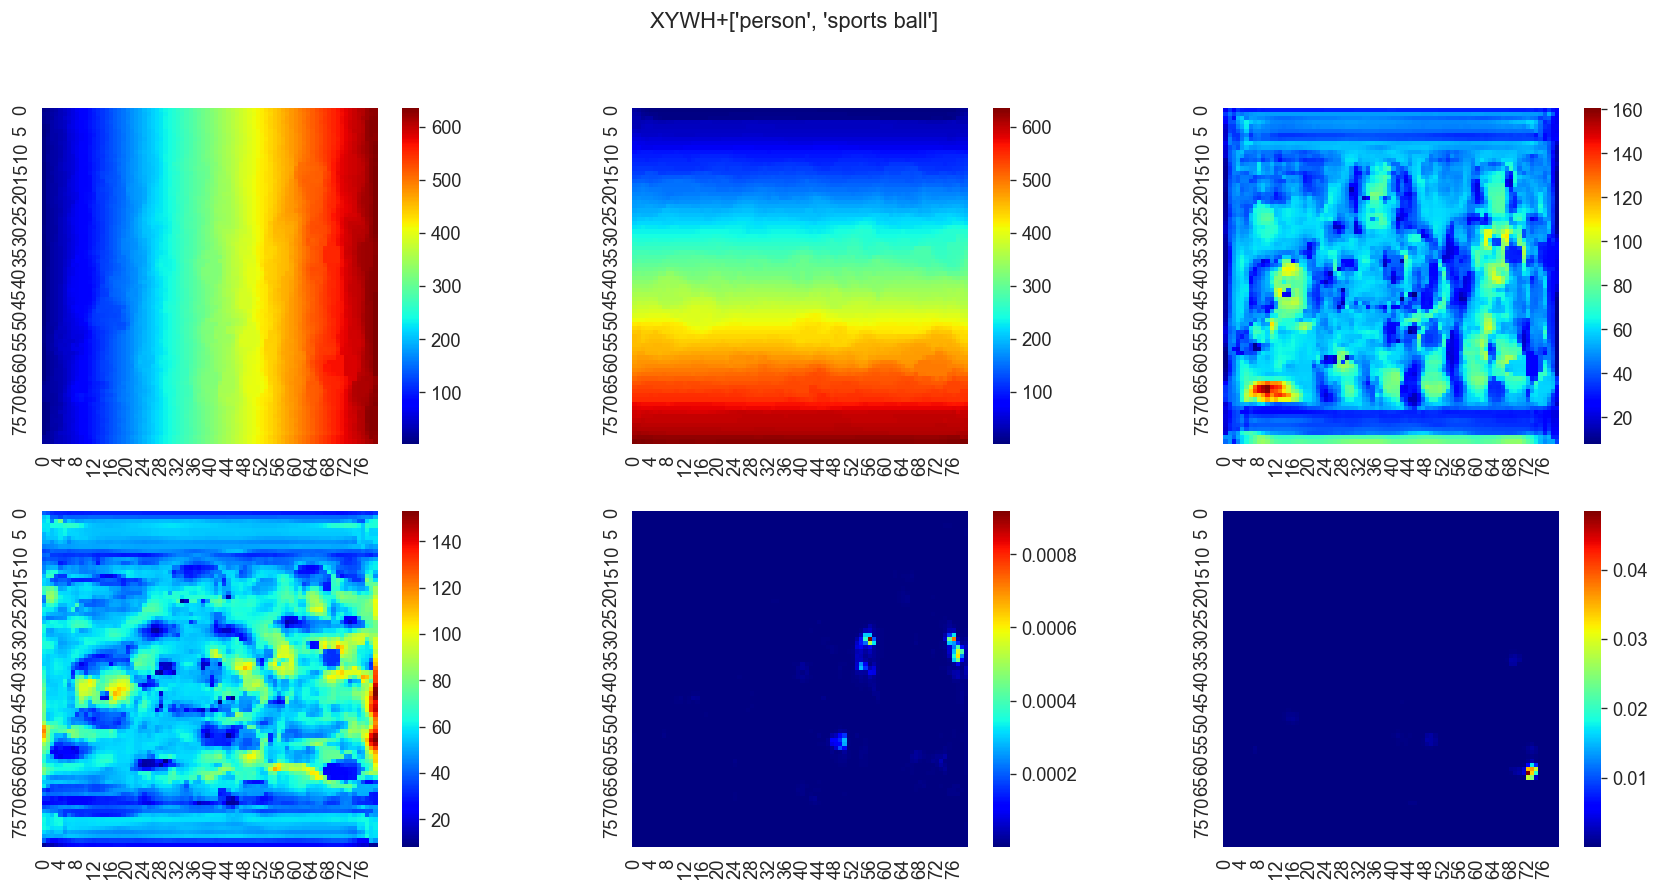

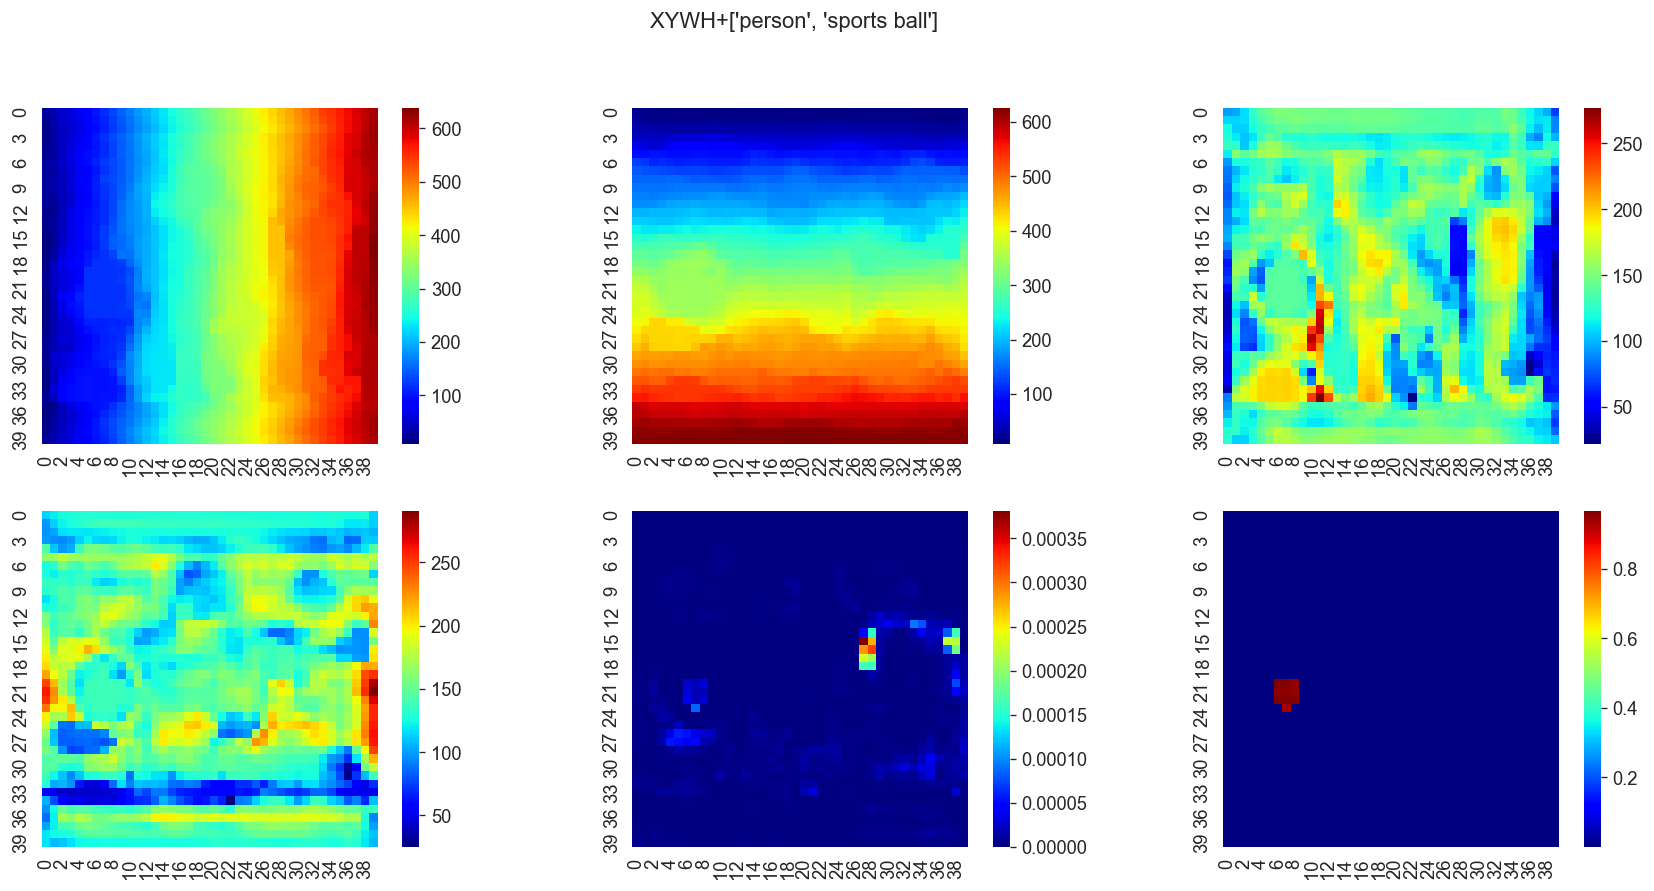

In [11]:
decoupled_classes = list(set(nms_preds.T[-1].astype(np.uint32).tolist()))    #XYWH+Classes
decoupled_classes.sort()
for i in decoupled_classes:
    print(f"{i:02d}: {model.names[i]}")
decoupled_indexes = [0,1,2,3,] + list(set((4+nms_preds).T[-1].astype(np.uint32).tolist()))    #XYWH+Classes
decoupled_indexes.sort()
for head in heads:
    plot_multi_heatmaps(*head[decoupled_indexes, ...], title=f"XYWH+{[model.names[i] for i in decoupled_classes]}")

In [12]:
conf_filter_heads = []
for head in heads:
    cls, y, x = torch.where(head[4:].cpu() >= conf_threshold)
    conf_filter_heads.append(np.array([cls.numpy(), y.numpy(), x.numpy()]))
conf_filter_heads

[array([], shape=(3, 0), dtype=int64),
 array([[32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
        [20, 20, 20, 21, 21, 21, 22, 22, 22, 23],
        [ 6,  7,  8,  6,  7,  8,  6,  7,  8,  7]], dtype=int64),
 array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12],
        [ 7,  8,  9, 15, 16, 17,  7,  8,  9, 15, 16, 17,  7,  8,  9, 15, 16, 17,  8, 16]], dtype=int64)]

Text(0.5, 1.0, 'Predict without NMS: 30 bboxes')

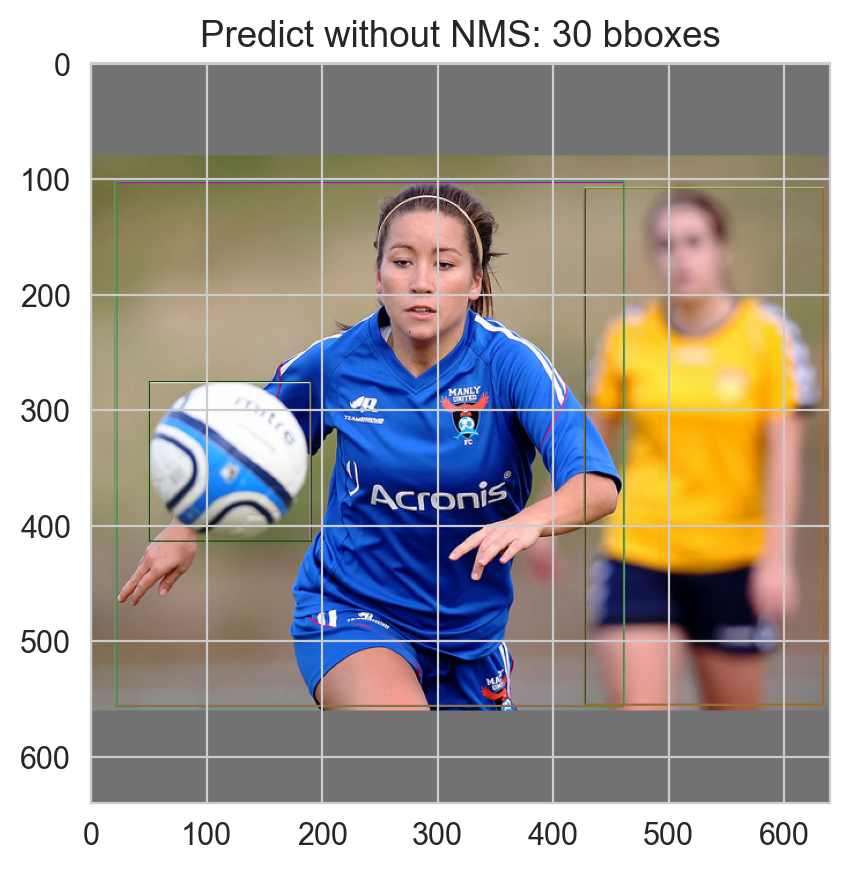

In [13]:
input_img = input_img0.copy()
for i, fiter_head in enumerate(conf_filter_heads):
    for cls, y, x in fiter_head.T:
        xywh = heads[i][:4, y, x].cpu().numpy()
        xy1 = np.ceil(xywh[:2] - xywh[2:] / 2).astype(np.uint32)
        xy2 = np.ceil(xywh[:2] + xywh[2:] / 2).astype(np.uint32)
        conf = heads[i][cls, y, x]
        cv2.rectangle(input_img, xy1, xy2, tuple(random.randint(0, 255) for _ in range(3)), thickness=1)
        # cv2.putText(input_img, f"{model.names[cls]} {100 * conf:.2f}%", (xy1[0], xy2[1]), color=(0, 127, 255), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5)

plt.imshow(input_img)
plt.title(f"Predict without NMS: {sum(i.shape[1] for i in conf_filter_heads)} bboxes")